In [724]:
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from math import cos, pi
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import levinson_durbin
from Levinson_Durbin.levinson import levinson_1d
import IPython
import struct
import bitarray
import copy

In [725]:
def error(coef, segment):
    e = np.zeros(256)
    n = 256
    
    for i in range(n):
        e[i] = segment[i]
        for j in range(0, 10):
            if i - j > 0:
                e[i] = e[i] + coef[j] * segment[i-j]
    
    return e

In [726]:
def quantize(signal, partitions, codebook):
    indices = []
    quanta = []
    for datum in signal:
        index = 0
        while index < len(partitions) and datum > partitions[index]:
            index += 1
        indices.append(index)
        quanta.append(codebook[index])
    return indices, quanta

In [727]:
def quantiz(quant_lvl, e, e_max):
    e_max = int(e_max)
    interval = (2 * e_max)/(quant_lvl-1)
    if interval == 0:
        partition = [1]
    else:
        partition = [x for x in range(-e_max,e_max,int(interval))]
    u = interval + e_max
    codebook = [x for x in range(quant_lvl)]
    _, quant = quantize(e, partition, codebook)
    return quant

In [728]:
# Weight for flattening edges
def weight(k: int):
    return 0.5*(1-cos(((2*pi) / (257)) * k))

In [729]:
def play_sound(sound, rate=11025):
    return  IPython.display.display(IPython.display.Audio(sound, rate=rate))
# Read wave file
track, fs = sf.read("data/01.wav")

play_sound(track[:])


(array([[4.62055571e-16, 4.66802140e-15, 5.83068033e-15, ...,
         2.97899976e-08, 6.10711716e-09, 6.43565587e-09],
        [1.20600157e-14, 2.61203130e-15, 4.34569778e-15, ...,
         1.43575478e-07, 4.00727449e-08, 1.25366771e-08],
        [3.39977054e-15, 1.82536646e-15, 6.30105840e-16, ...,
         1.84028861e-08, 2.27256226e-08, 3.05275311e-08],
        ...,
        [7.78530960e-12, 1.08669877e-11, 4.36559365e-11, ...,
         1.49187790e-09, 2.79682071e-06, 1.58887545e-06],
        [5.43831055e-11, 3.02893484e-11, 4.38738322e-11, ...,
         1.52823370e-09, 1.70265383e-06, 1.05708607e-06],
        [6.24042927e-12, 2.03939890e-11, 4.19493981e-12, ...,
         5.87810463e-10, 1.17218164e-07, 1.93440216e-08]]),
 array([   0.        ,   10.76660156,   21.53320312,   32.29980469,
          43.06640625,   53.83300781,   64.59960938,   75.36621094,
          86.1328125 ,   96.89941406,  107.66601562,  118.43261719,
         129.19921875,  139.96582031,  150.73242188,  161.499

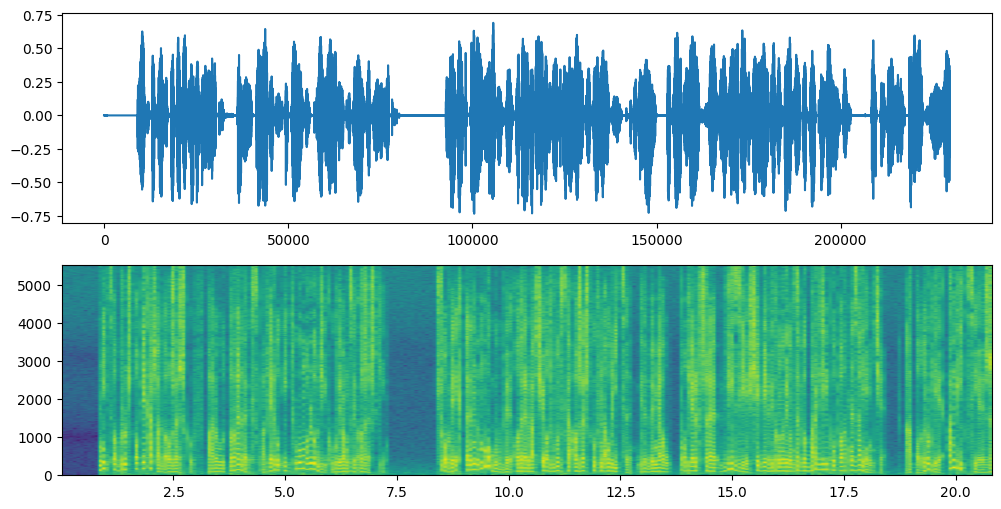

In [730]:
# Ploting track with specgram
plt.figure(figsize=(12,6))

plt.subplot(2, 1, 1)
plt.plot(track)

plt.subplot(2, 1, 2)
plt.specgram(track, NFFT=1024, Fs=fs)

# plt.show()

In [731]:
# Creating segments with 256 samples 
segments = [track[:256]]
for i in range(256, len(track), 256):
    segments.append(track[i:i+256])

In [732]:
# Cell for printing purposes
segments[0]

array([ 6.10351562e-05, -6.10351562e-05,  9.15527344e-05, -9.15527344e-05,
        1.52587891e-04, -2.44140625e-04,  2.44140625e-04, -2.13623047e-04,
        1.22070312e-04, -6.10351562e-05,  1.52587891e-04, -3.35693359e-04,
        3.35693359e-04, -2.13623047e-04,  1.22070312e-04, -6.10351562e-05,
       -3.05175781e-05,  3.05175781e-05,  6.10351562e-05, -6.10351562e-05,
        6.10351562e-05, -6.10351562e-05, -3.05175781e-05,  1.22070312e-04,
       -1.22070312e-04,  2.13623047e-04, -2.13623047e-04,  1.52587891e-04,
       -1.83105469e-04,  1.83105469e-04, -1.83105469e-04,  1.83105469e-04,
       -6.10351562e-05, -1.52587891e-04,  3.35693359e-04, -4.57763672e-04,
        3.96728516e-04, -2.13623047e-04,  9.15527344e-05, -3.05175781e-05,
        9.15527344e-05, -1.83105469e-04,  1.52587891e-04, -1.52587891e-04,
        1.83105469e-04, -9.15527344e-05,  0.00000000e+00, -3.05175781e-05,
       -6.10351562e-05,  1.52587891e-04, -1.22070312e-04,  9.15527344e-05,
       -9.15527344e-05,  

In [733]:
# Filling last segments with zeros to make it 256 samples long
new_last_segment = np.append(segments[-1], np.zeros(13))
segments[-1] = new_last_segment

In [734]:
# Checking if all segments are 256 samples long
correct_len_segments = 0
for i in range(0, len(segments)):
    if len(segments[i]) == 256:
        correct_len_segments += 1
    else:
        print(f">>> Len for segment {i+1} is different and equals {len(segments[i])})")
if correct_len_segments == len(segments):
    print(f"All segments are length of 256 samples!")
else:
    print(f"Segments with length = {correct_len_segments}")

All segments are length of 256 samples!


In [735]:
# Prepare variable for storing flattened segments
flatten_segments = copy.copy(segments)
flatten_segments[0]

array([ 6.10351562e-05, -6.10351562e-05,  9.15527344e-05, -9.15527344e-05,
        1.52587891e-04, -2.44140625e-04,  2.44140625e-04, -2.13623047e-04,
        1.22070312e-04, -6.10351562e-05,  1.52587891e-04, -3.35693359e-04,
        3.35693359e-04, -2.13623047e-04,  1.22070312e-04, -6.10351562e-05,
       -3.05175781e-05,  3.05175781e-05,  6.10351562e-05, -6.10351562e-05,
        6.10351562e-05, -6.10351562e-05, -3.05175781e-05,  1.22070312e-04,
       -1.22070312e-04,  2.13623047e-04, -2.13623047e-04,  1.52587891e-04,
       -1.83105469e-04,  1.83105469e-04, -1.83105469e-04,  1.83105469e-04,
       -6.10351562e-05, -1.52587891e-04,  3.35693359e-04, -4.57763672e-04,
        3.96728516e-04, -2.13623047e-04,  9.15527344e-05, -3.05175781e-05,
        9.15527344e-05, -1.83105469e-04,  1.52587891e-04, -1.52587891e-04,
        1.83105469e-04, -9.15527344e-05,  0.00000000e+00, -3.05175781e-05,
       -6.10351562e-05,  1.52587891e-04, -1.22070312e-04,  9.15527344e-05,
       -9.15527344e-05,  

In [736]:
# Flattening samples in each segment
for i in range(0, len(flatten_segments)):
    for n in range(1, len(flatten_segments[i])):
        flatten_segments[i][n] *= weight(n)

In [737]:
# Ready flattened segments for Levinson-Durbin identification
flatten_segments[0]

array([ 6.10351562e-05, -9.11993887e-09,  5.47114570e-08, -1.23070122e-07,
        3.64525078e-07, -9.10904174e-07,  1.31098330e-06, -1.56033359e-06,
        1.16369358e-06, -7.35776104e-07,  2.26876383e-06, -6.03312840e-06,
        7.17168980e-06, -5.34945353e-06,  3.54042671e-06, -2.02919327e-06,
       -1.15260012e-06,  1.29903465e-06,  2.90762542e-06, -3.23368358e-06,
        3.57604889e-06, -3.93451673e-06, -2.15443643e-06,  9.39778700e-06,
       -1.02086912e-05,  1.93374536e-05, -2.08619795e-05,  1.60270544e-05,
       -2.06264586e-05,  2.20628433e-05, -2.35407611e-05,  2.50593286e-05,
       -8.87254605e-06, -2.35122986e-05,  5.47245136e-05, -7.88039749e-05,
        7.19968706e-05, -4.08005720e-05,  1.83741651e-05, -6.42624956e-06,
        2.01991694e-05, -4.22697546e-05,  3.68088550e-05, -3.84165141e-05,
        4.80561743e-05, -2.50192645e-05,  0.00000000e+00, -9.01274596e-06,
       -1.87098848e-05,  4.85033375e-05, -4.01988584e-05,  3.12056252e-05,
       -3.22708154e-05,  

In [738]:
# Prepare variable for storing AR coefficients assigned by LD algorithm
ld_arcoefs = []

In [739]:
# Imported from LD
# If True use levinson_dubrin
LD = True
for x in range(0, len(flatten_segments)):
    if LD:
        errors, arcoefs, reflection_coefs, sigmas, phi = levinson_durbin(flatten_segments[x],10)
    else:
        arcoefs, errors, reflection_coefs = levinson_1d(flatten_segments[x],10)
    ld_arcoefs.append(arcoefs)
len(ld_arcoefs)

897

In [740]:
segments[0]

array([ 6.10351562e-05, -9.11993887e-09,  5.47114570e-08, -1.23070122e-07,
        3.64525078e-07, -9.10904174e-07,  1.31098330e-06, -1.56033359e-06,
        1.16369358e-06, -7.35776104e-07,  2.26876383e-06, -6.03312840e-06,
        7.17168980e-06, -5.34945353e-06,  3.54042671e-06, -2.02919327e-06,
       -1.15260012e-06,  1.29903465e-06,  2.90762542e-06, -3.23368358e-06,
        3.57604889e-06, -3.93451673e-06, -2.15443643e-06,  9.39778700e-06,
       -1.02086912e-05,  1.93374536e-05, -2.08619795e-05,  1.60270544e-05,
       -2.06264586e-05,  2.20628433e-05, -2.35407611e-05,  2.50593286e-05,
       -8.87254605e-06, -2.35122986e-05,  5.47245136e-05, -7.88039749e-05,
        7.19968706e-05, -4.08005720e-05,  1.83741651e-05, -6.42624956e-06,
        2.01991694e-05, -4.22697546e-05,  3.68088550e-05, -3.84165141e-05,
        4.80561743e-05, -2.50192645e-05,  0.00000000e+00, -9.01274596e-06,
       -1.87098848e-05,  4.85033375e-05, -4.01988584e-05,  3.12056252e-05,
       -3.22708154e-05,  

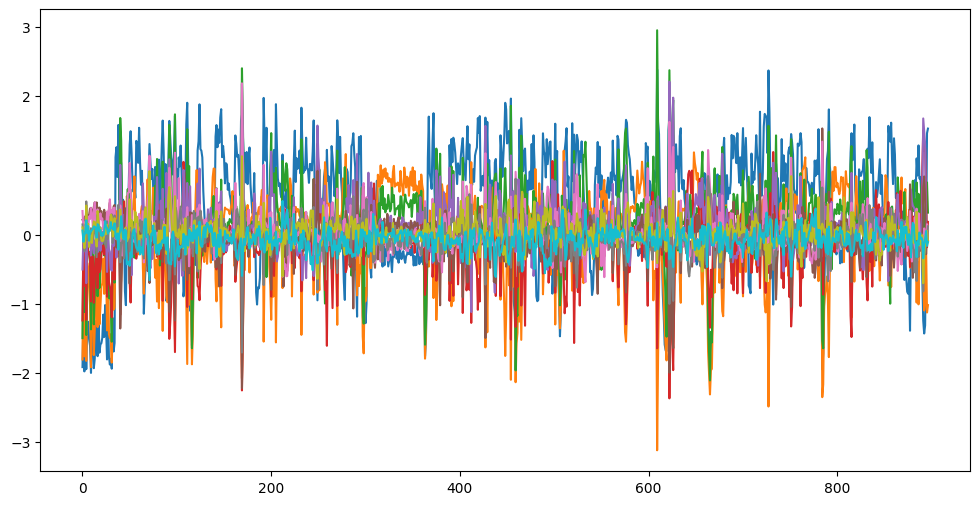

In [741]:
plt.figure(figsize=(12,6))

plt.plot(ld_arcoefs)

plt.show()

In [742]:
# Assigning error values
e = []
e_max = []
quantz = []
for i in range(len(segments)):
    e.append(error(ld_arcoefs[i], segments[i]))
    e_max.append(max(abs(e[i])))
    quantz.append(quantiz(3, e[i], e_max[i]))

In [743]:
segments

[array([ 6.10351562e-05, -9.11993887e-09,  5.47114570e-08, -1.23070122e-07,
         3.64525078e-07, -9.10904174e-07,  1.31098330e-06, -1.56033359e-06,
         1.16369358e-06, -7.35776104e-07,  2.26876383e-06, -6.03312840e-06,
         7.17168980e-06, -5.34945353e-06,  3.54042671e-06, -2.02919327e-06,
        -1.15260012e-06,  1.29903465e-06,  2.90762542e-06, -3.23368358e-06,
         3.57604889e-06, -3.93451673e-06, -2.15443643e-06,  9.39778700e-06,
        -1.02086912e-05,  1.93374536e-05, -2.08619795e-05,  1.60270544e-05,
        -2.06264586e-05,  2.20628433e-05, -2.35407611e-05,  2.50593286e-05,
        -8.87254605e-06, -2.35122986e-05,  5.47245136e-05, -7.88039749e-05,
         7.19968706e-05, -4.08005720e-05,  1.83741651e-05, -6.42624956e-06,
         2.01991694e-05, -4.22697546e-05,  3.68088550e-05, -3.84165141e-05,
         4.80561743e-05, -2.50192645e-05,  0.00000000e+00, -9.01274596e-06,
        -1.87098848e-05,  4.85033375e-05, -4.01988584e-05,  3.12056252e-05,
        -3.2

In [744]:
# Computing errors for each sample in each segment
errors_og = []
for segment, k in zip(segments, ld_arcoefs):
    e = []
    for i in range(0, len(segment)):
        error = 0
        for j in range(0, 10):
            if i-j >= 0:
                error += k[j] * segment[i-j]
        e.append(error)
    errors_og.append(e)

In [745]:
errors_og[0]

[-0.00011688821490333938,
 -0.00011017148586228022,
 -9.142864576041547e-05,
 -7.56120760363278e-05,
 -3.135980061283739e-05,
 1.4207340638310998e-05,
 1.9438789585036022e-05,
 1.0480242957567328e-05,
 5.860971740654911e-06,
 3.996963335865244e-06,
 -3.5660801963317593e-06,
 7.91581882069899e-06,
 -5.90110830492894e-06,
 3.7168109066330073e-06,
 -1.4168956427565612e-06,
 -4.0022700588961514e-08,
 3.00161468638554e-06,
 7.348090215368929e-07,
 -4.846525837701447e-06,
 9.421037574435342e-07,
 -6.004402066182073e-06,
 1.0904045271903027e-06,
 8.074032023552693e-06,
 -1.0141302904830965e-05,
 9.14022445496546e-06,
 -2.7851564456510414e-05,
 1.0021901328824056e-05,
 -1.548460535087418e-05,
 2.3820553640743696e-05,
 -1.2364569232995047e-05,
 2.8329995076440733e-05,
 -1.9511819257095042e-05,
 -1.1368859619433172e-05,
 4.105547417964299e-05,
 -6.9323353719549e-05,
 8.561301374296866e-05,
 -4.450718799056463e-05,
 1.4328040862562004e-05,
 -4.630307672082591e-06,
 -5.76673961065846e-06,
 -4.1388

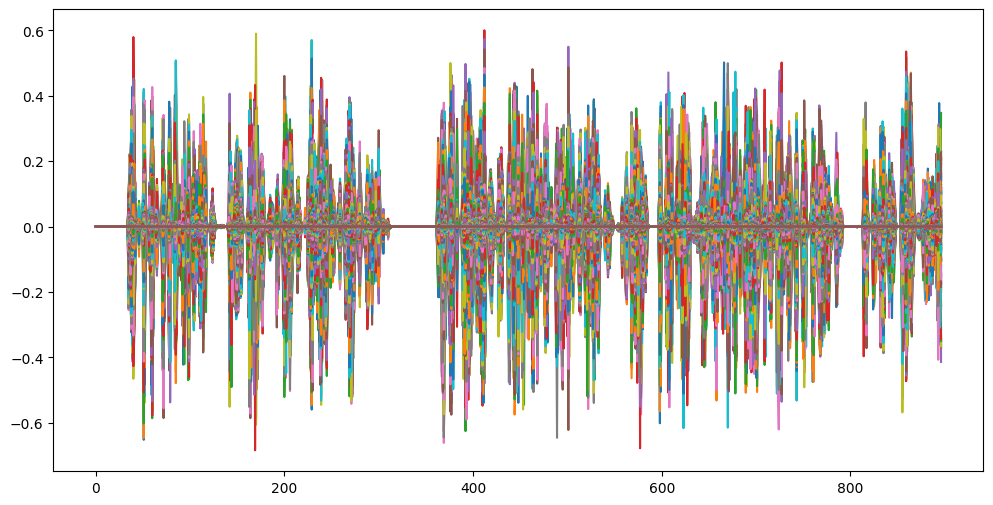

In [746]:
plt.figure(figsize=(12,6))

plt.plot(errors_og)

plt.show()

In [747]:
# Computing max error absolute value for each segment
e_max_list = []
for segment in errors_og:
    e_max = segment[0]
    for i in range(0, len(segment)):
        if abs(segment[i]) > e_max:
            e_max = abs(segment[i])
    e_max_list.append(e_max)
len(e_max_list)

897

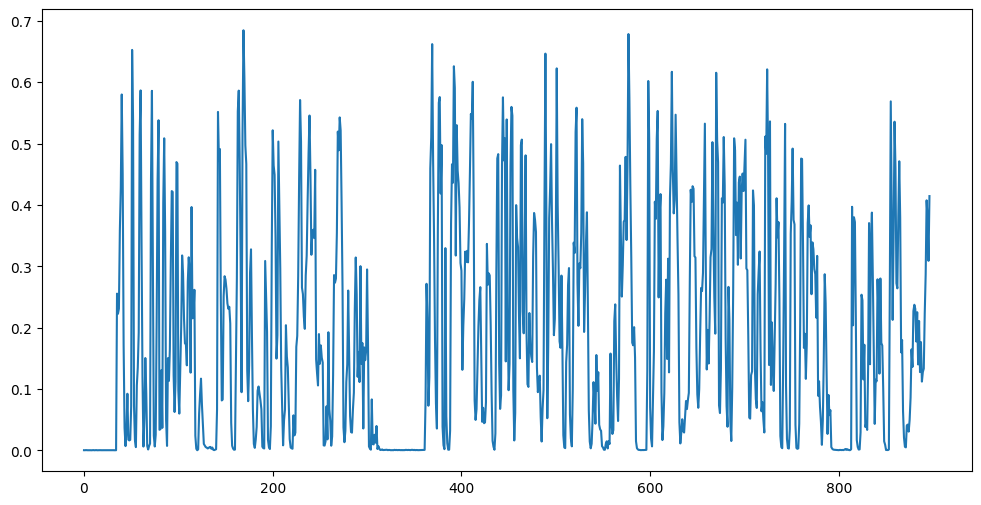

In [748]:
plt.figure(figsize=(12,6))

plt.plot(e_max_list)

plt.show()

In [749]:
# Compute quantz
# quantz = []
# for i in range(len(segments)):
#     quantz.append(quantiz(3, errors_og[i], e_max_list[i]))
# quantz

In [750]:
quant_level = 4
quants = []
for idx, e in enumerate(errors_og):
    e_plus = [x + e_max_list[idx] for x in e]
    step = (2 * e_max_list[idx]) / (quant_level - 1)
    if step == 0:
        quant = np.round(e_plus)
    else:
        quant = np.round(e_plus/step)
    quants.append(quant)
quants

[array([1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 1., 2., 1., 2., 1., 1., 2.,
        2., 1., 2., 1., 2., 2., 1., 2., 1., 2., 1., 2., 1., 2., 1., 1., 2.,
        1., 2., 1., 2., 1., 1., 1., 2., 1., 2., 1., 1., 1., 2., 2., 1., 2.,
        1., 2., 2., 1., 2., 1., 2., 1., 2., 1., 2., 1., 2., 2., 1., 2., 1.,
        1., 2., 2., 1., 2., 1., 2., 1., 2., 1., 2., 2., 1., 2., 1., 2., 2.,
        1., 2., 1., 2., 1., 2., 1., 1., 2., 1., 3., 1., 2., 1., 2., 2., 1.,
        2., 0., 2., 1., 2., 1., 2., 2., 1., 2., 1., 2., 2., 1., 2., 1., 1.,
        2., 1., 1., 2., 1., 2., 1., 1., 2., 0., 2., 0., 3., 0., 3., 1., 1.,
        2., 2., 1., 1., 1., 1., 2., 2., 1., 1., 2., 1., 3., 0., 2., 1., 1.,
        2., 2., 1., 2., 1., 1., 2., 1., 2., 1., 2., 1., 2., 1., 2., 2., 1.,
        1., 1., 2., 1., 2., 1., 1., 2., 1., 3., 0., 3., 1., 2., 2., 1., 2.,
        1., 2., 2., 1., 2., 2., 1., 2., 1., 2., 1., 2., 2., 1., 2., 1., 2.,
        1., 2., 1., 2., 1., 2., 1., 2., 1., 2., 1., 2., 1., 1., 2., 1., 2.,
        2., 

In [751]:
len(quants[0])

256

In [752]:
with open('data/e_max.bin', 'wb') as f:
    for i in range(len(e_max_list)):
        f.write(e_max_list[i])

In [753]:
bits = bitarray.bitarray()
with open('data/a.bin', 'rb') as f:
    st = f.read()
st


b''

In [754]:
quantization_lvl = (max(max(quantz)) + 1)
quantization_lvl

3

In [755]:
y2 = np.zeros(897*256)

In [723]:
interval

0.0

In [722]:
for i in range(len(segments)):
    interval = (2 * int(e_max_list[i]))/(quantization_lvl-1)
    if interval == 0:
        partition = [0]
    else:
        partition = [x for x in range(-int(e_max_list[i]),int(e_max_list[i]),int(interval))]
        print(f"partition={partition}")
    for j in range(256):
        x = 0
        for k in range(10):
            if j - k > 0:
                x = x + ld_arcoefs[i][k] * y2[j-k]
        y2[(i-1)*256+j] = -x + partition[quantz[i][j]-1]

y2 = np.int16(y2)

sf.write("data/test.wav", y2, 11025)
play_sound(y2)

IndexError: list index out of range